<a href="https://colab.research.google.com/github/gabrie1-s/phosphorus_analysis/blob/main/Analise_fosforo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing libraries and reading data

In [117]:
%%capture
!pip install Bayesian-Optimization
!pip install xgboost
!pip install ray

In [118]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics
import math
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [119]:
import os
import gc
import pdb
import ray
import keras
import xgboost
import tensorflow
from scipy import stats
from sklearn import metrics
from xgboost import XGBRegressor
from keras.models import load_model
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go

In [120]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [121]:
fosforo = pd.read_excel("/content/drive/MyDrive/CNN_Chagas/fosforo/Dados_B1_B7.xlsx")

In [122]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [123]:
fosforo.columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'P']

In [124]:
dataset = fosforo[fosforo.columns[:7]]

In [125]:
target = fosforo['P']

# 2. Histograms / Skew

In [126]:
df = dataset.copy()
df['P'] = target

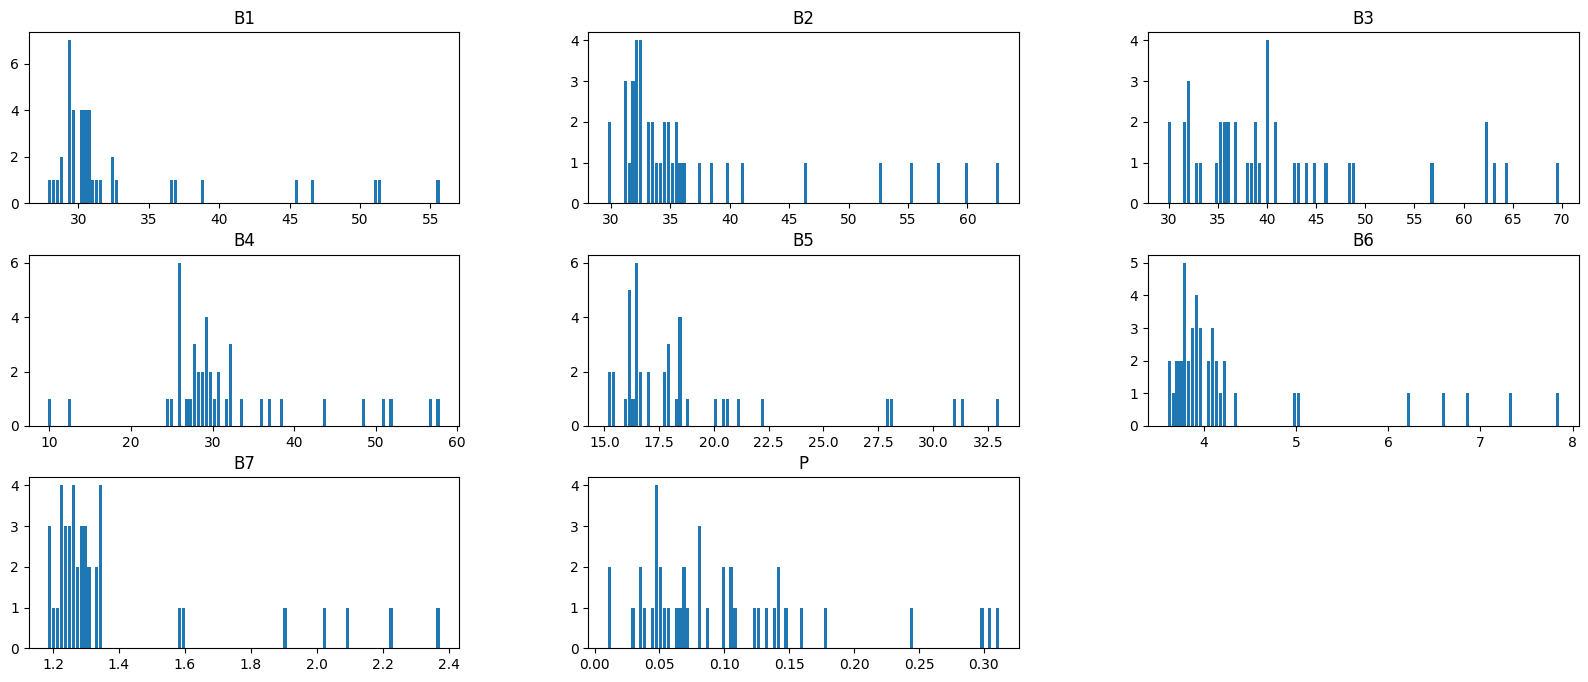

In [127]:
df.hist(
    figsize=(20, 8),
    grid = False,
    rwidth = 0.8,
    bins = 100
)
plt.show()

In [128]:
df.skew()

B1    2.202681
B2    2.021795
B3    1.406842
B4    0.991740
B5    2.011601
B6    2.300812
B7    2.306189
P     1.565691
dtype: float64

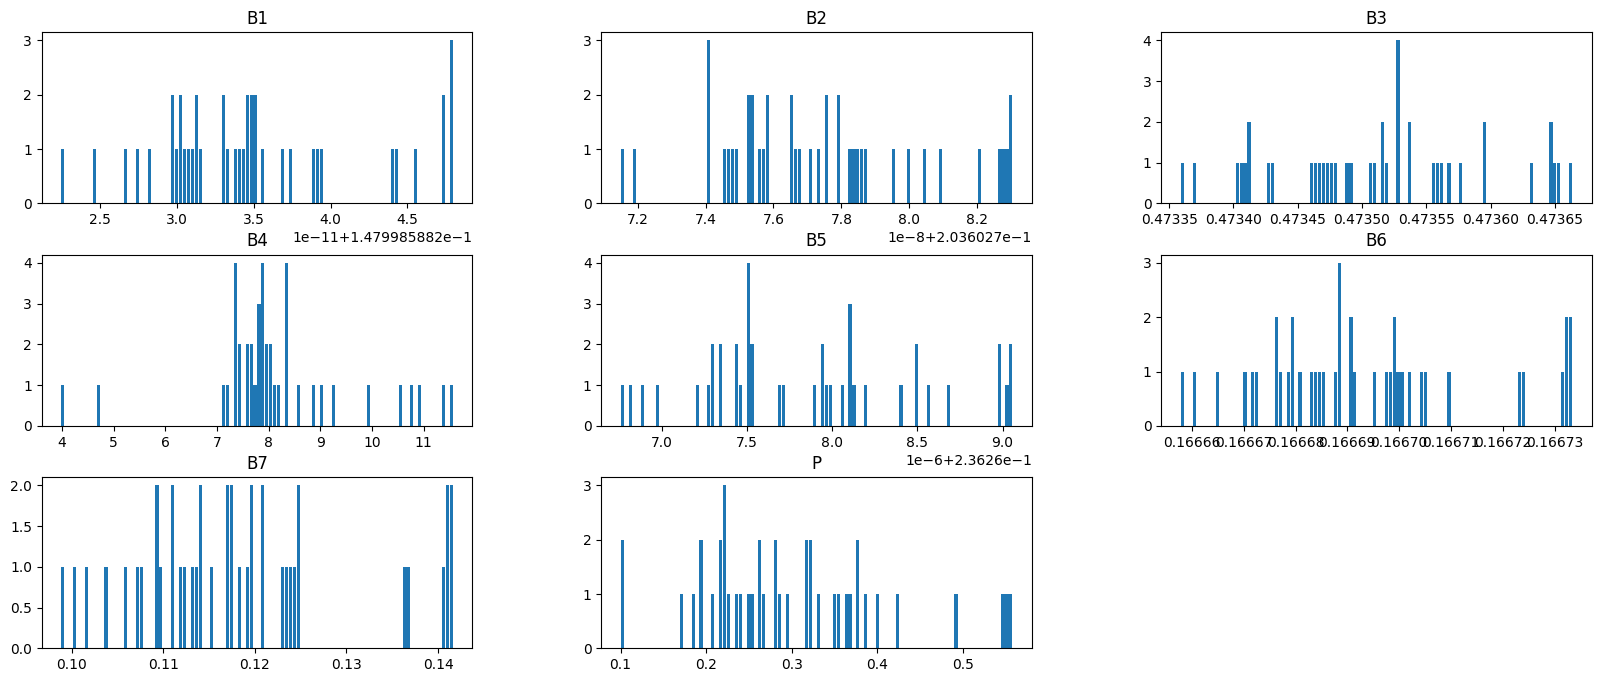

In [129]:
lbs = []

for col in df.columns:
  if abs(df.skew()[col]) > 0.9:
    df[col], l = stats.boxcox(df[col])[0:2]
    lbs.append(l)

target = np.sqrt(target)
df['P'] = target

df.hist(
    figsize=(20, 8),
    grid = False,
    rwidth = 0.8,
    bins = 100
)
plt.show()

In [130]:
lbs

[-6.756821209151582,
 -4.911524211710275,
 -2.1109315692577852,
 0.4495494212091018,
 -4.232461187722476,
 -5.997571733575384,
 -7.043710808407542,
 0.199055449196808]

In [131]:
df.skew()

B1    0.000000
B2    0.000000
B3    0.135525
B4    0.100529
B5    0.000000
B6    0.583387
B7    0.628361
P     0.712777
dtype: float64

In [132]:
dataset = df[df.columns[:7]]
target = df['P']

# 3. Boxplots

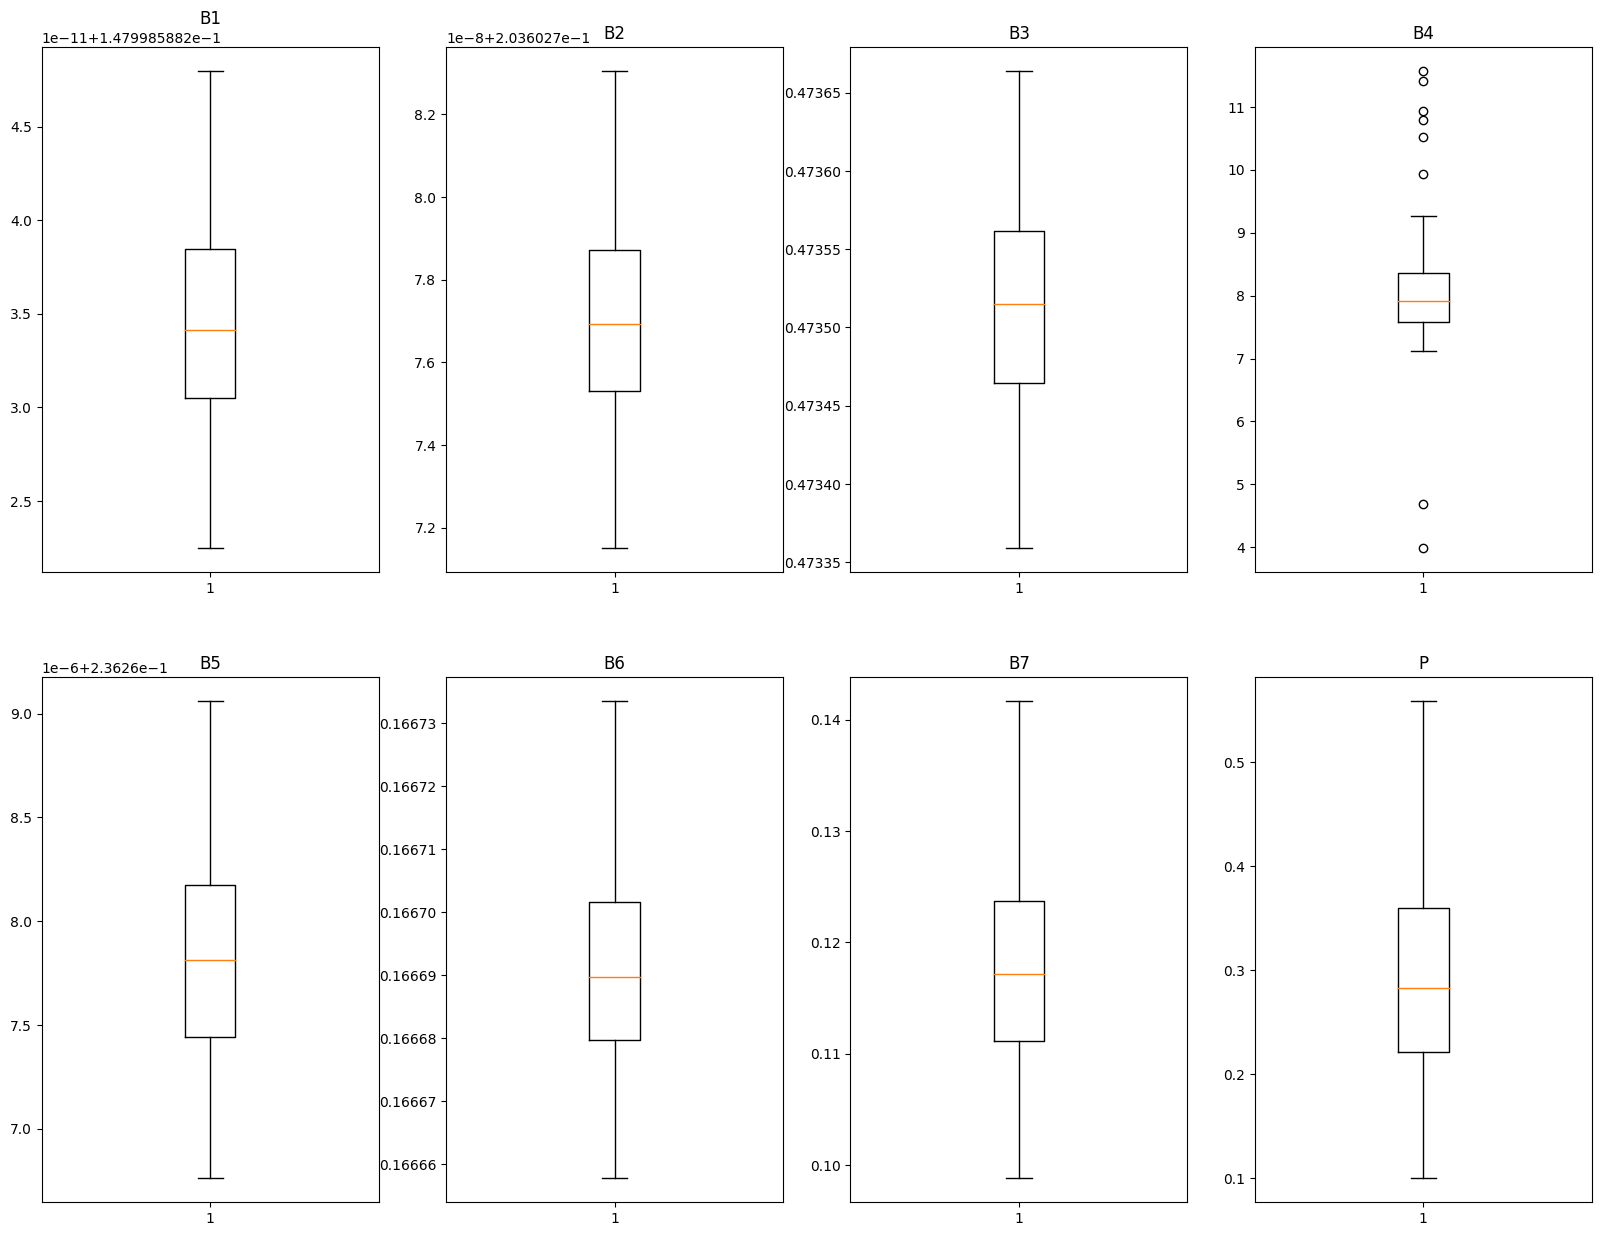

In [133]:
i=0
j=0

df = dataset.copy()
df['P'] = target

plt.rcParams["figure.figsize"] = (20,15)
fig, axs = plt.subplots(2, 4)
for col in df.columns:
  axs[i,j].set_title(col)
  axs[i,j].boxplot(df[col])
  j +=1

  if j > 3:
    j = 0
    i +=1

plt.show()

# 4. Outliers Removal

In [ ]:
def outliers_treatment(dataset, target, method='remotion', median_p_dist=0.1, target_dist=0.1):
  if method == 'median':
    for i, p1 in enumerate(target):
      similar = [i]
      for j, p2 in enumerate(target):
        if abs(p1-p2) < target_dist*p1:
          similar.append(j)

      for k in range(len(dataset.columns)):
        for j in similar:
          if abs(dataset.iloc[i, k] - dataset.iloc[j, k]) > median_p_dist*dataset.iloc[i, k]:
            dataset.iloc[i, k] = statistics.median([dataset.iloc[c, k] for c in similar])
            dataset.iloc[j, k] = statistics.median([dataset.iloc[c, k] for c in similar])


  elif method == 'remotion':
    to_drop = []
    for i, p1 in enumerate(target):
      similar = [i]
      for j, p2 in enumerate(target):
        if abs(p1-p2) < target_dist*p1:
          similar.append(j)

      for k in range(len(dataset.columns)):
        if abs(dataset.iloc[i, k] - statistics.median([dataset.iloc[c, k] for c in similar])) >  median_p_dist*dataset.iloc[i, k]:
          to_drop.append(i)
          break

    dataset = dataset.drop(index=to_drop)
    dataset.reset_index(drop=True, inplace=True)
    target = target.drop(index=to_drop)
    target.reset_index(drop=True, inplace=True)

  return dataset, target


In [ ]:
to_drop = [val for val in target.index if target[val] > 0.2]
dataset = dataset.drop(index=to_drop)
dataset.reset_index(drop=True, inplace=True)
target = target.drop(index=to_drop)
target.reset_index(drop=True, inplace=True)

In [ ]:
dataset, target = outliers_treatment(dataset, target, method='remotion', median_p_dist=0.15)

In [ ]:
dataset

# 5. Polynomial Relations

In [134]:
# for i in dataset.columns:
#   dataset['ln('+str(i)+')'] = np.log(dataset[i])

for i in dataset.columns:
  dataset['1/' + str(i)] = 1/dataset[i]

In [135]:
dataset

,B1,B2,B3,B4,B5,B6,B7,1/B1,1/B2,1/B3,1/B4,1/B5,1/B6,1/B7
0,0.147999,0.203603,0.473529,3.982859,0.236268,0.166685,0.113798,6.756821,4.911524,2.111802,0.251076,4.232483,5.999346,8.787533
1,0.147999,0.203603,0.473491,7.785559,0.236268,0.166673,0.107064,6.756821,4.911524,2.111973,0.128443,4.232490,5.999779,9.340167
2,0.147999,0.203603,0.473515,7.873793,0.236268,0.166684,0.111881,6.756821,4.911524,2.111867,0.127004,4.232483,5.999387,8.938059
3,0.147999,0.203603,0.473536,7.975267,0.236268,0.166677,0.107604,6.756821,4.911524,2.111770,0.125388,4.232484,5.999618,9.293368
4,0.147999,0.203603,0.473516,8.044982,0.236268,0.166688,0.113320,6.756821,4.911524,2.111862,0.124301,4.232480,5.999239,8.824582
5,0.147999,0.203603,0.473648,10.512614,0.236269,0.166732,0.140976,6.756821,4.911524,2.111274,0.095124,4.232464,5.997643,7.093418
6,0.147999,0.203603,0.473428,7.378002,0.236267,0.166683,0.112486,6.756821,4.911524,2.112254,0.135538,4.232492,5.999408,8.889978
7,0.147999,0.203603,0.473430,7.568932,0.236268,0.166692,0.117618,6.756821,4.911524,2.112246,0.132119,4.232491,5.999098,8.502097
8,0.147999,0.203603,0.473359,7.115098,0.236267,0.166658,0.098792,6.756821,4.911524,2.112563,0.140546,4.232504,6.000320,10.122309
9,0.147999,0.203603,0.473413,7.358776,0.236267,0.166680,0.111105,6.756821,4.911524,2.112321,0.135892,4.232494,5.999531,9.000521


In [136]:
poly = PolynomialFeatures(degree=7, include_bias=False)
poly_features = poly.fit_transform(dataset)
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(dataset.columns))

# 6. Selection by Correlation

In [ ]:
def one_side_corr(data, target, method='spearman', target_corr=0.5, variables_corr=0.5):
    other_columns = [col for col in data.columns if col != target]
    values = []
    accepted_cols = []
    accepted_values = []
    for col in other_columns:
      corr_value = data[target].corr(data[col], method=method)
      if corr_value > target_corr:
        values.append((col, corr_value))

    values = sorted(values, key=lambda x: x[1], reverse=True)
    accepted_cols.append(values[0][0])
    accepted_values.append(values[0])

    for i in values:
      count = 0
      for col_acc in accepted_cols:
        if abs(data[col_acc].corr(data[i[0]], method=method)) > variables_corr:
          count += 1
          break
      if count == 0:
        accepted_cols.append(i[0])
        accepted_values.append(i)

    return accepted_values

In [ ]:
poly_df['P'] = target
poly_corr = one_side_corr(poly_df, 'P',method="pearson", target_corr=0.5, variables_corr=0.7)

In [ ]:
poly_corr

[('ln(B2)^3 ln(B5) 1/B7', 0.8345547422836394),
 ('B7 ln(B2) ln(B5) 1/B6 1/ln(B1)^2', 0.6332850537111244),
 ('B4 ln(B6) 1/B6 1/ln(B3)^2', 0.6147422491490465),
 ('B7 ln(B1) ln(B2) ln(B3) 1/B1 1/ln(B6)', 0.6093953487315484),
 ('B4 B6 B7 ln(B1) 1/B1 1/ln(B7)', 0.6071016960730681),
 ('ln(B5)^3 1/ln(B1)^2 1/ln(B3)', 0.6029634577995863),
 ('B2 ln(B2) ln(B4)^2 1/B6^2', 0.5947036839386304),
 ('B3 B5 ln(B1) 1/B1 1/B4 1/ln(B4)', 0.5836126856058041),
 ('B5 ln(B2) ln(B4) 1/B6 1/ln(B3)^2', 0.5820235606573781),
 ('B7 ln(B5)^2 ln(B6)^2 1/ln(B7)', 0.5795719986104793),
 ('B2 ln(B7) 1/B7^2 1/ln(B6)^2', 0.5715416646195635),
 ('B2^2 ln(B1) ln(B4) 1/B5 1/B6', 0.5603613875533671),
 ('B2 B3 ln(B2) 1/B4 1/B7 1/ln(B4)', 0.5495042883573498),
 ('B2 ln(B3)^2 ln(B5) 1/B3 1/ln(B6)', 0.5397458448948792),
 ('B7^2 ln(B5) 1/B6^2', 0.5324763899661035),
 ('B2^3 1/B1^2 1/B4', 0.5270549628597453),
 ('B2 B5 B6 1/B4 1/B7^2', 0.5134802278950671)]

In [ ]:
poly_df = poly_df[[x[0] for x in poly_corr]]

In [ ]:
y = target
x = poly_df

# 7.PCA

In [137]:
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)
pca = PCA()
x_pca = pca.fit_transform(poly_df)

In [138]:
cumulative_variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

val = list(range(1, len(cumulative_variance)+1))
fig = go.Figure(data=go.Scatter(x = val, y = cumulative_variance, mode='lines+markers'))
fig.update_layout(
    xaxis=dict(title='PCs', dtick=10 ,showgrid=True),
    yaxis=dict(title='Cumulative variance',  dtick=10, showgrid=True)
)
fig.show()

In [139]:
x = pd.DataFrame()
y = target

for i, val in enumerate(np.transpose(x_pca[:, :41])[0:]):
  x['pc_' + str(i+1)] = val

# 8. Train/Test Split

In [65]:
from sklearn.model_selection import StratifiedKFold, KFold

In [71]:
def fold_visualizer(data, fold_idxs, seed_num):
    fig, axs = plt.subplots(len(fold_idxs)//2, 2, figsize=(15,(len(fold_idxs)//2)*5))
    fig.suptitle("Seed: " + str(seed_num), fontsize=16)
    for fold_id, (train_ids, val_ids) in enumerate(fold_idxs):
        sns.histplot(data=data[train_ids],
                     kde=True,
                     stat="density",
                     alpha=0.15,
                     label="Train Set",
                     bins=10,
                     line_kws={"linewidth":4},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        sns.histplot(data=data[val_ids],
                     kde=True,
                     stat="density",
                     color="darkorange",
                     alpha=0.15,
                     label="Validation Set",
                     bins=10,
                     line_kws={"linewidth":4},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].legend()
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].set_title("Split " + str(fold_id+1))
    plt.show()

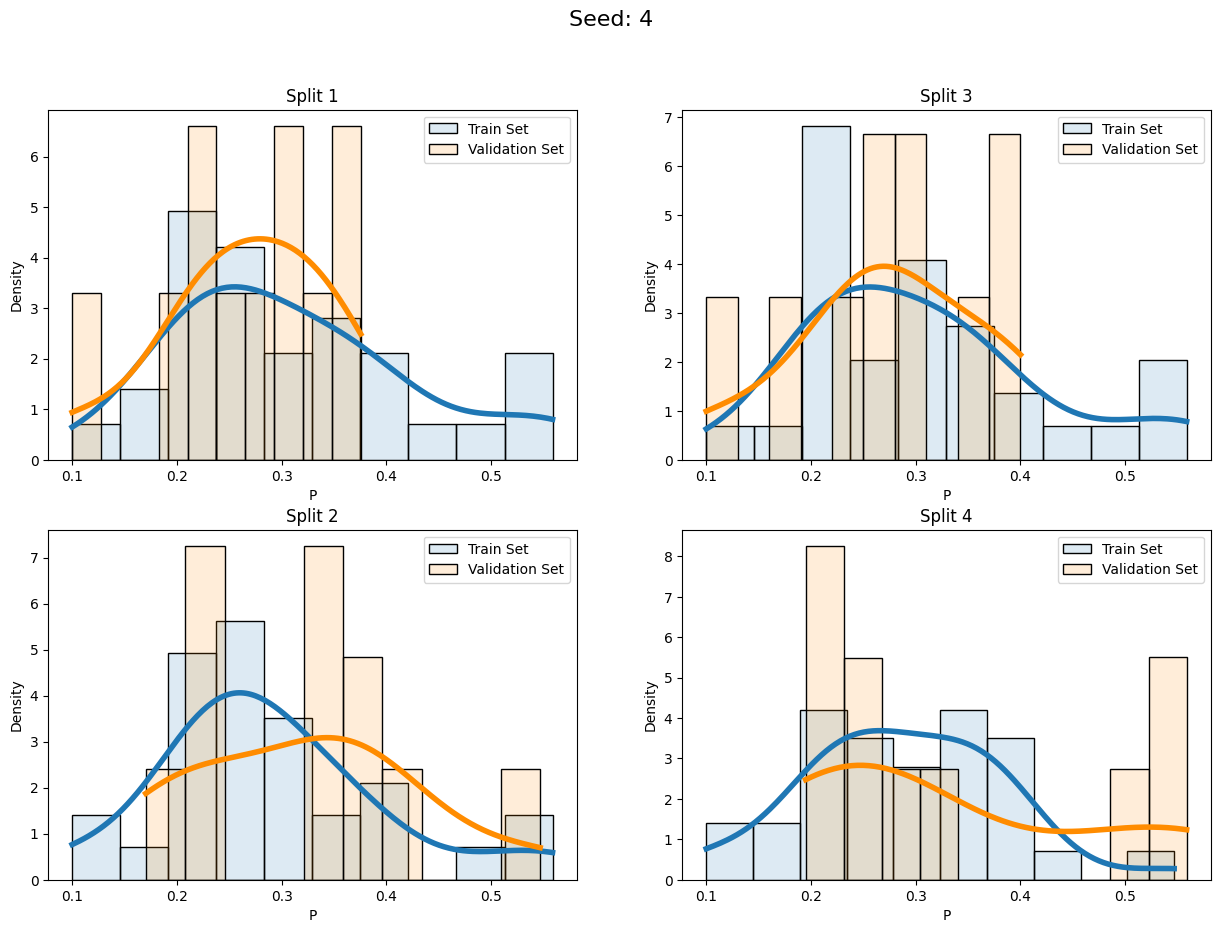

In [72]:
plt.rcParams["figure.figsize"] = (8,5)


baseline_kfold = list(KFold(4,
                            shuffle=True,
                            random_state=3
                            ).split(target))
fold_visualizer(data=target,
                fold_idxs=baseline_kfold,
                seed_num=4)

In [79]:
def create_cont_folds(df, n_s=8, n_grp=10, seed=1):

    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=seed)
    grp = pd.cut(df, n_grp, labels=False)
    target = grp

    fold_nums = np.zeros(len(df))
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        fold_nums[v] = fold_no

    cv_splits = []

    for i in range(n_s):
        test_indices = np.argwhere(fold_nums==i).flatten()
        train_indices = list(set(range(len(df))) - set(test_indices))
        cv_splits.append((train_indices, test_indices))

    return cv_splits

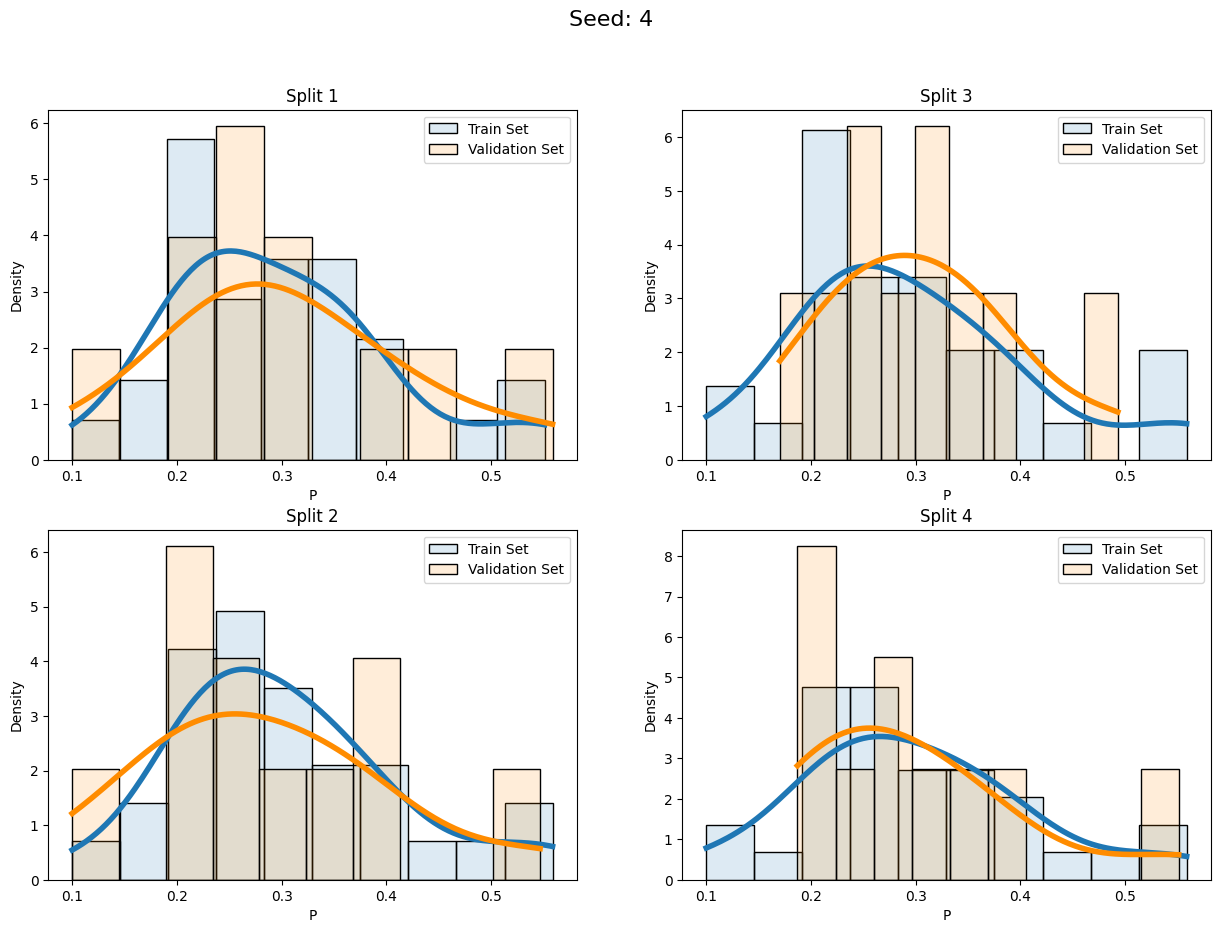

In [80]:
num_of_folds = 4
num_of_groups = 5

cv_splits = create_cont_folds(target, n_s=num_of_folds, n_grp=num_of_groups, seed=i)
fold_visualizer(data=target,
                fold_idxs=cv_splits,
                seed_num=4)

In [149]:
cv_splits = create_cont_folds(y, n_s=8, n_grp=10, seed=4)
x_tr = x.iloc[cv_splits[5][0]]
y_tr = y.iloc[cv_splits[5][0]]
x_te = x.iloc[cv_splits[5][1]]
y_te = y.iloc[cv_splits[5][1]]

# 9. Variable Selection

## 9.1. Boruta

In [140]:
%%capture
!pip install BorutaShap
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [142]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from BorutaShap import BorutaShap, load_data
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Random Forest

In [150]:
forest = RandomForestRegressor(
   n_jobs = -1, n_estimators=200
)

Feature_Selector = BorutaShap(model=forest,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

1 attributes confirmed important: ['pc_5']
40 attributes confirmed unimportant: ['pc_38', 'pc_2', 'pc_23', 'pc_34', 'pc_35', 'pc_13', 'pc_6', 'pc_24', 'pc_7', 'pc_25', 'pc_12', 'pc_1', 'pc_11', 'pc_10', 'pc_8', 'pc_20', 'pc_33', 'pc_21', 'pc_18', 'pc_16', 'pc_28', 'pc_17', 'pc_37', 'pc_14', 'pc_36', 'pc_41', 'pc_26', 'pc_27', 'pc_15', 'pc_30', 'pc_19', 'pc_4', 'pc_39', 'pc_9', 'pc_40', 'pc_29', 'pc_32', 'pc_3', 'pc_22', 'pc_31']
0 tentative attributes remains: []


### Gradient Boosting

In [151]:
gb = GradientBoostingRegressor(
   n_estimators=200
)

Feature_Selector = BorutaShap(model=gb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

3 attributes confirmed important: ['pc_26', 'pc_5', 'pc_13']
38 attributes confirmed unimportant: ['pc_38', 'pc_2', 'pc_23', 'pc_34', 'pc_35', 'pc_6', 'pc_24', 'pc_7', 'pc_25', 'pc_12', 'pc_1', 'pc_11', 'pc_10', 'pc_8', 'pc_20', 'pc_33', 'pc_21', 'pc_18', 'pc_16', 'pc_28', 'pc_17', 'pc_37', 'pc_14', 'pc_36', 'pc_41', 'pc_27', 'pc_15', 'pc_30', 'pc_19', 'pc_4', 'pc_39', 'pc_9', 'pc_40', 'pc_29', 'pc_32', 'pc_3', 'pc_22', 'pc_31']
0 tentative attributes remains: []


### CatBoost

In [152]:
ctb = CatBoostRegressor(iterations=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=ctb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

1 attributes confirmed important: ['pc_13']
40 attributes confirmed unimportant: ['pc_38', 'pc_2', 'pc_23', 'pc_34', 'pc_35', 'pc_6', 'pc_24', 'pc_7', 'pc_25', 'pc_12', 'pc_1', 'pc_11', 'pc_10', 'pc_8', 'pc_20', 'pc_33', 'pc_21', 'pc_18', 'pc_16', 'pc_28', 'pc_17', 'pc_5', 'pc_14', 'pc_37', 'pc_36', 'pc_41', 'pc_26', 'pc_27', 'pc_15', 'pc_30', 'pc_19', 'pc_4', 'pc_39', 'pc_9', 'pc_40', 'pc_29', 'pc_32', 'pc_3', 'pc_22', 'pc_31']
0 tentative attributes remains: []


### XGBoost

In [153]:
xgb = XGBRegressor(n_estimators=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=xgb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_tr, y=y_tr, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

2 attributes confirmed important: ['pc_5', 'pc_13']
37 attributes confirmed unimportant: ['pc_38', 'pc_23', 'pc_35', 'pc_34', 'pc_2', 'pc_6', 'pc_24', 'pc_7', 'pc_25', 'pc_12', 'pc_1', 'pc_11', 'pc_10', 'pc_33', 'pc_20', 'pc_21', 'pc_18', 'pc_16', 'pc_28', 'pc_37', 'pc_17', 'pc_14', 'pc_36', 'pc_41', 'pc_26', 'pc_27', 'pc_15', 'pc_30', 'pc_19', 'pc_39', 'pc_40', 'pc_9', 'pc_29', 'pc_32', 'pc_3', 'pc_22', 'pc_31']
2 tentative attributes remains: ['pc_4', 'pc_8']


In [154]:
x_tr = x_tr[['pc_26', 'pc_5', 'pc_13', 'pc_4', 'pc_8']]

x_te = x_te[['pc_26', 'pc_5', 'pc_13', 'pc_4', 'pc_8']]

df = x[['pc_26', 'pc_5', 'pc_13', 'pc_4', 'pc_8']].copy()
df['P'] = y

In [155]:
eigenvectors = pca.components_
eigenvectors = [eigenvectors[1]]
variables = poly_df.columns  # Adjust this based on your actual variable names

for i, comp in enumerate(eigenvectors):
    terms = [f"{comp[j]:.3f}*{variables[j]}" for j in range(len(variables)) if round(comp[j],3) != 0]
    formula = " + ".join(terms)
    print(f"Principal Component {i+1}: {formula}")

Principal Component 1: 0.001*B4^4 1/B7 + 0.001*B4^3 1/B7^2 + 0.001*B4^2 1/B1 1/B7^2 + 0.001*B4^2 1/B2 1/B7^2 + 0.001*B4^2 1/B5 1/B7^2 + 0.001*B4^2 1/B6 1/B7^2 + 0.002*B4^2 1/B7^3 + 0.001*B4 1/B1^2 1/B7^2 + 0.001*B4 1/B1 1/B2 1/B7^2 + 0.001*B4 1/B1 1/B6 1/B7^2 + 0.001*B4 1/B1 1/B7^3 + 0.001*B4 1/B2 1/B7^3 + 0.001*B4 1/B5 1/B7^3 + 0.001*B4 1/B6^2 1/B7^2 + 0.001*B4 1/B6 1/B7^3 + 0.002*B4 1/B7^4 + 0.001*1/B1^3 1/B7^2 + 0.001*1/B1^2 1/B7^3 + 0.001*1/B1 1/B2 1/B7^3 + 0.001*1/B1 1/B5 1/B7^3 + 0.001*1/B1 1/B6 1/B7^3 + 0.002*1/B1 1/B7^4 + 0.001*1/B2^2 1/B7^3 + 0.001*1/B2 1/B5 1/B7^3 + 0.001*1/B2 1/B6 1/B7^3 + 0.001*1/B2 1/B7^4 + 0.001*1/B3 1/B7^4 + 0.001*1/B5 1/B6 1/B7^3 + 0.001*1/B5 1/B7^4 + 0.001*1/B6^2 1/B7^3 + 0.002*1/B6 1/B7^4 + 0.003*1/B7^5 + 0.001*B2 1/B7^5 + 0.001*B3 B4^2 1/B7^3 + 0.001*B3 B4 1/B1 1/B7^3 + 0.001*B3 B4 1/B6 1/B7^3 + 0.001*B3 B4 1/B7^4 + 0.001*B3 1/B1^2 1/B7^3 + 0.001*B3 1/B1 1/B7^4 + 0.001*B3 1/B2 1/B7^4 + 0.001*B3 1/B5 1/B7^4 + 0.001*B3 1/B6 1/B7^4 + 0.002*B3 1/B7^5 + 0

# 10. Bivariate analysis / correlation between data

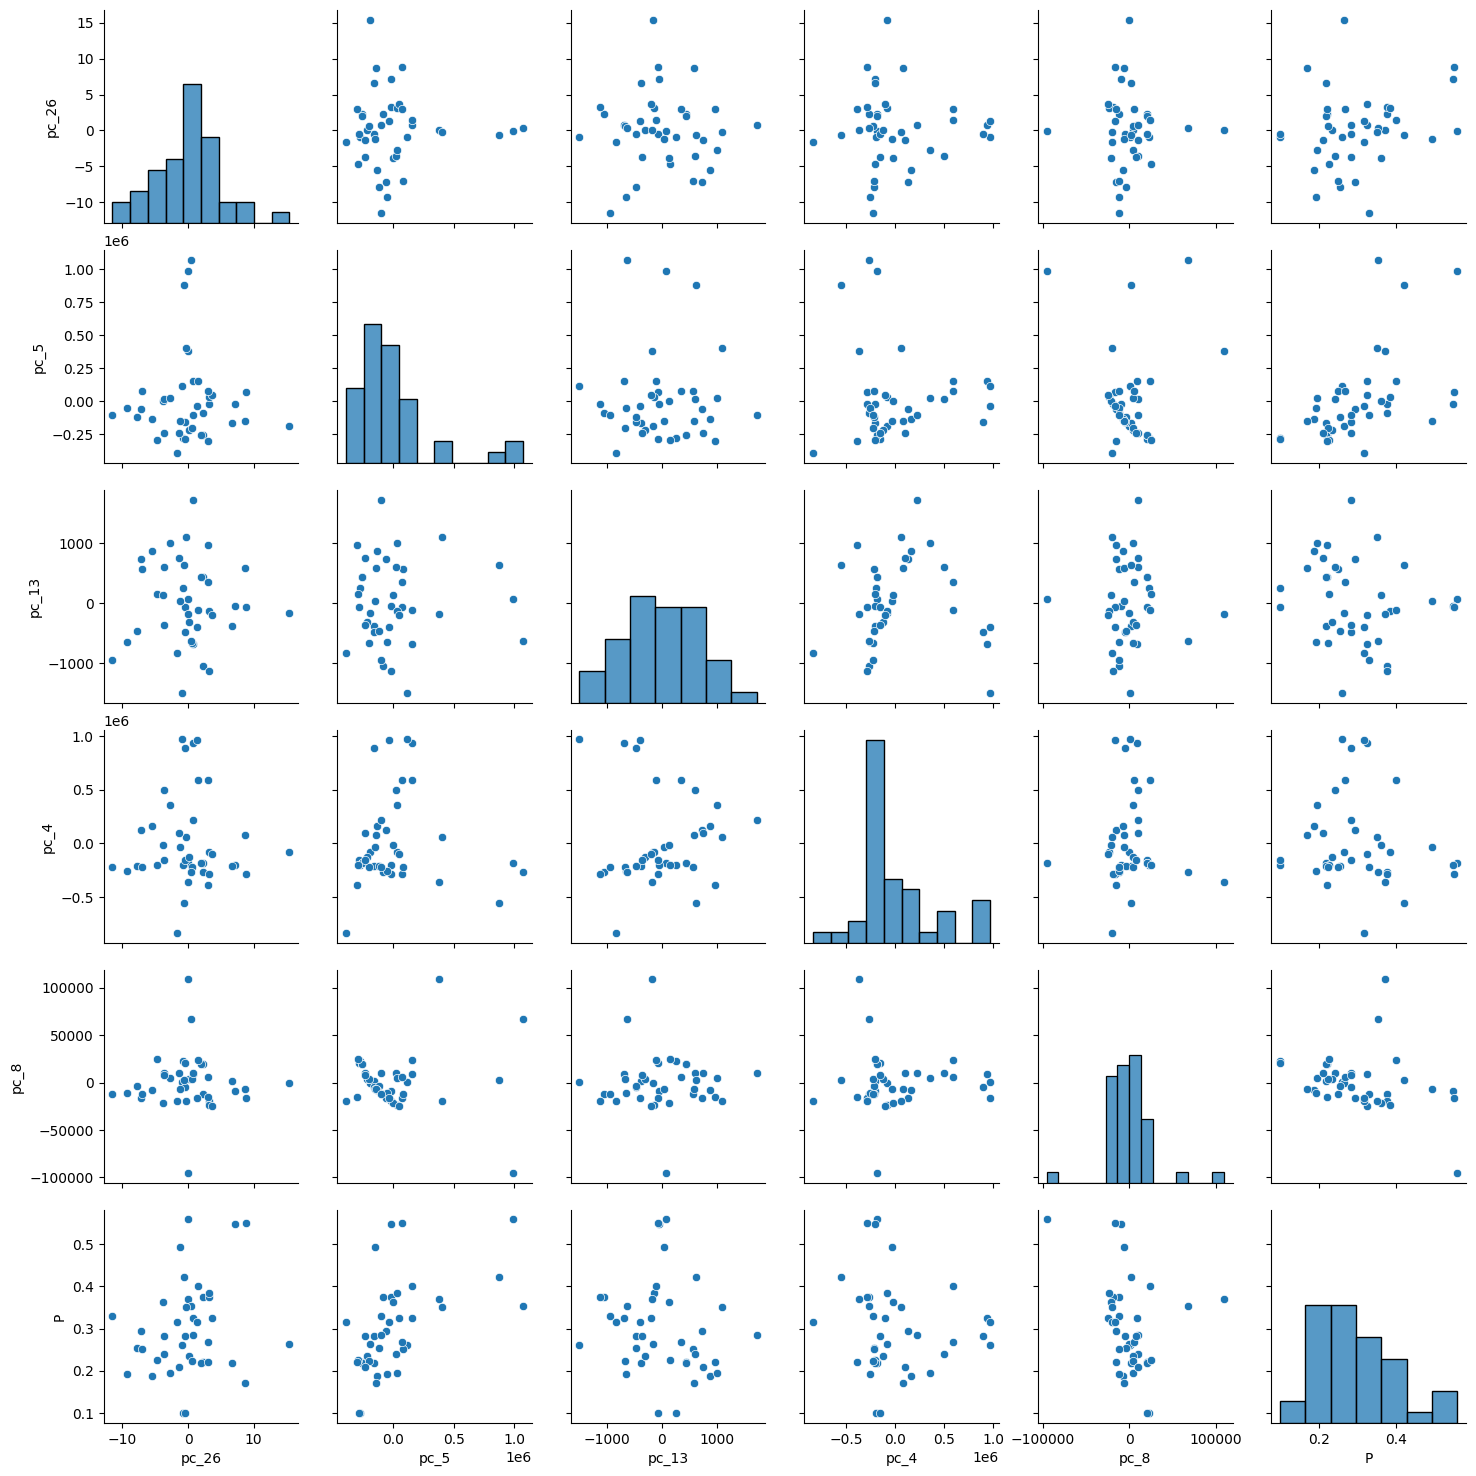

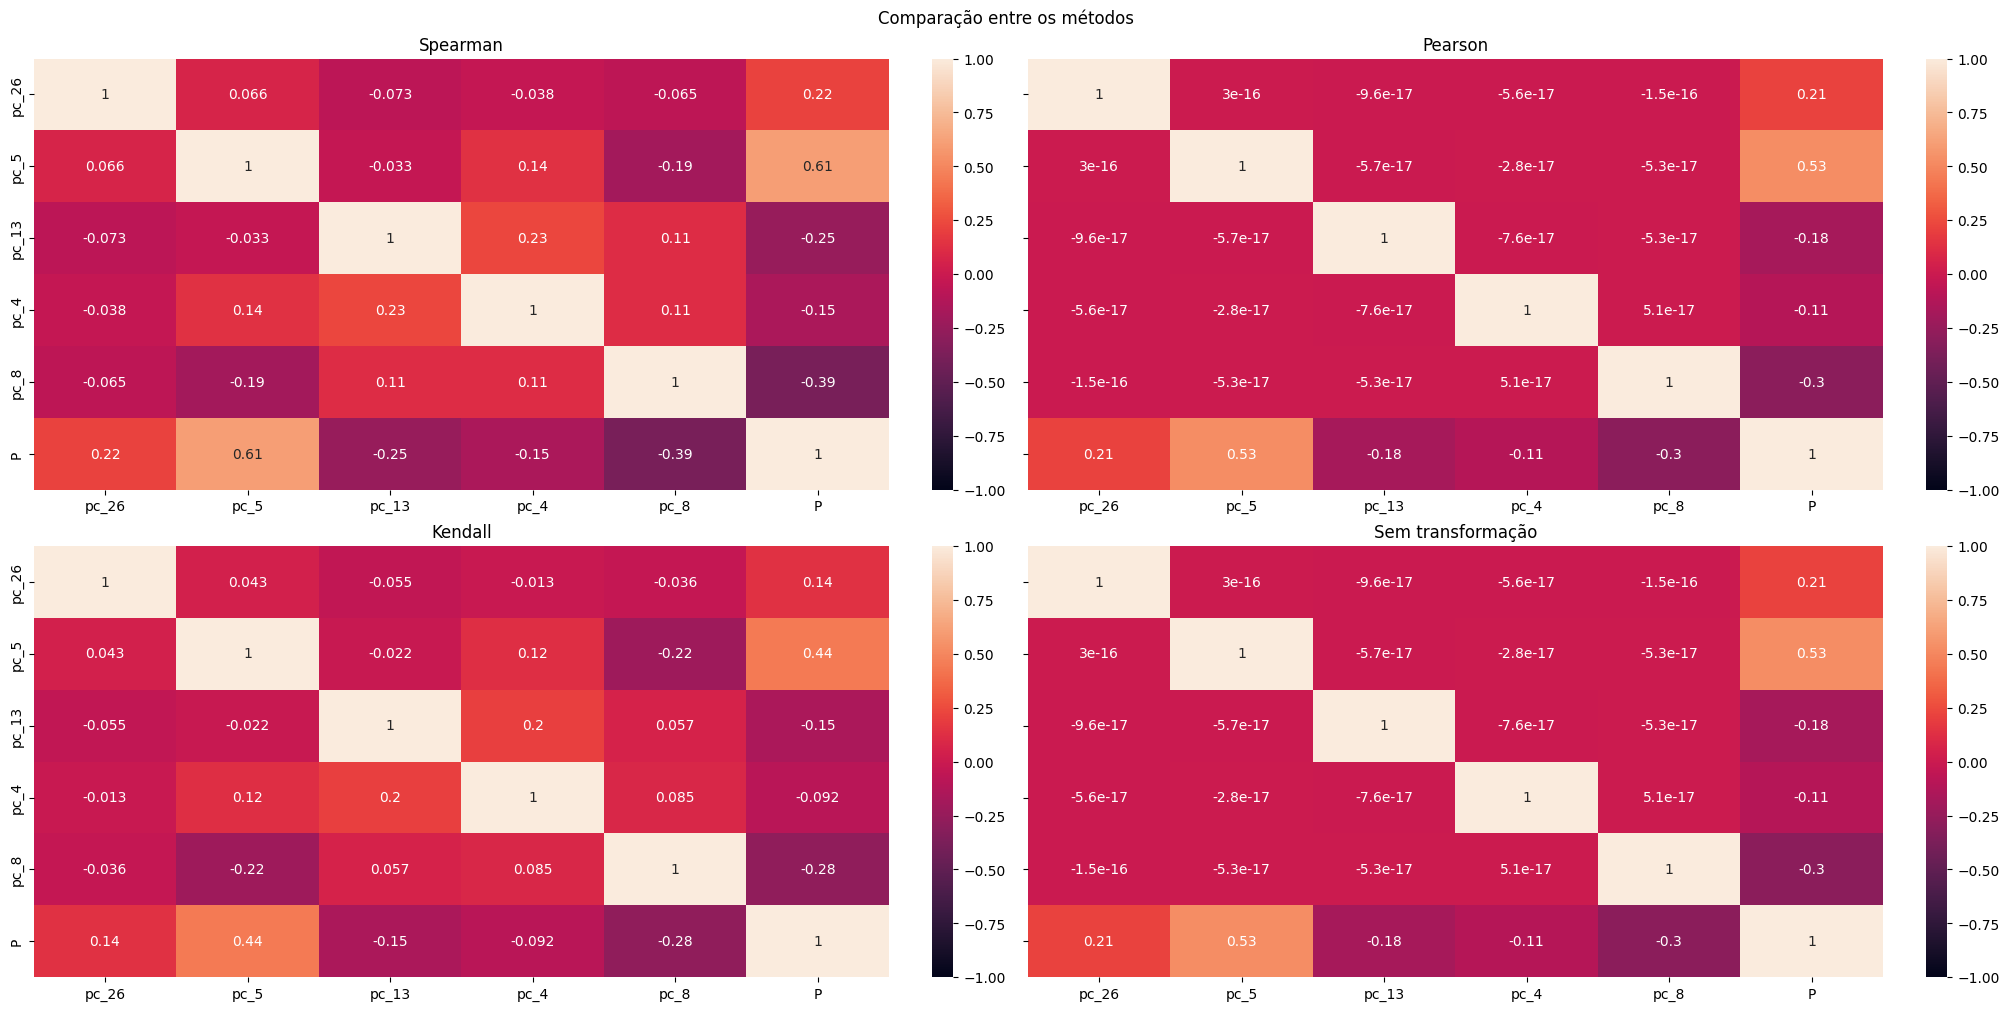

In [156]:
sns.pairplot(df)
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True, constrained_layout=True)
fig.suptitle('Comparação entre os métodos')

#Spearman
ax = sns.heatmap(df.corr(method='spearman'), annot=True, vmin=-1, vmax=1, ax = axes[0,0])
axes[0,0].set_title("Spearman")
bottom, top = ax.get_ylim()

#Pearson
ax = sns.heatmap(df.corr(method='pearson'), annot=True, vmin=-1, vmax=1, ax = axes[0,1])
axes[0,1].set_title("Pearson")
bottom, top = ax.get_ylim()

#Kendall
ax = sns.heatmap(df.corr(method='kendall'), annot=True, vmin=-1, vmax=1, ax = axes[1,0])
bottom, top = ax.get_ylim()
axes[1,0].set_title("Kendall")

#Sem transformação
ax = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, ax = axes[1,1])
axes[1,1].set_title("Sem transformação")
bottom, top = ax.get_ylim()

# 11. Regression Algorithms

In [157]:
def plot_results(y_pred, y_tes):
  plt.rcParams["figure.figsize"] = (10,5)
  plt.scatter(range(len(y_pred)), y_pred, c='r')
  plt.plot(range(len(y_tes)), y_tes, linestyle="-", marker="o", label="Expenses")
  plt.title('Model performance - test set')
  plt.ylabel('P medido')
  plt.xlabel('Sample')
  plt.legend(['predicted', 'real'], loc='upper left')
  plt.show()

Before we implement the regression models, I would like to clarify that we will use two main metrics to evaluate the performance of our models:


  * Mean Absolute Percentage Error (MAPE):
  \begin{equation}
    MAPE = \frac{1}{n} \sum_{i = 1}^{n} \frac{|y_i - p_i|}{y_i}
  \end{equation}

  * Mean Absolute Error (MAE):
  \begin{equation}
    MAE = \frac{1}{n} \sum_{i = 1}^{n} |y_i - p_i|
  \end{equation}

  * $R^2$ score:
  \begin{equation}
    R^2 = NSE = 1 - \frac{\sum_{i=1}^{N} (y_i - p_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y_i})^2}
  \end{equation}


Where $y_i$ is the actual value, $p_i$ is the value predicted by the tested model, and $\bar{y_i}$ is the average of the $y_i$ values, $\forall i$.


## 11.1. Linear Methods

In [158]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

In [159]:
def inverse_box_cox(y, lambda_):
  if lambda_ == 0:
    return np.exp(y)
  else:
    return np.log(1 + lambda_*y)/np.log(lambda_)

def inverse_square_root(y):
  return y**2

In [160]:
def cross_validation(x_train, y_train, folds, lambda_=None):

  splits = create_cont_folds(y_train, n_s=folds, n_grp=10, seed=4)
  x_tr = np.array(x_train)
  y_tr = np.array(y_train)
  histories = []
  models = []
  results = []


  for train_index, test_index in splits:
    xtr, xva = x_tr[train_index], x_tr[test_index]
    ytr, yva = y_tr[train_index], y_tr[test_index]

    model = sklm.LinearRegression()
    model.fit(xtr, ytr)
    y_pred = model.predict(xva)

    if lambda_ !=None:
      y_pred = inverse_square_root(y_pred)
      yva = inverse_square_root(yva)


    r2 = r2_score(yva, y_pred)
    mae = mean_absolute_error(yva, y_pred)
    mape = mean_absolute_percentage_error(yva, y_pred)
    mse = mean_squared_error(yva, y_pred)
    result = {'r2':r2, 'mae':mae, 'mape':mape, 'mse':mse}
    results.append(result)

  return results

In [161]:
def train_test_model(model, x_tr, y_tr, x_te, y_te, lambda_=None, folds=5):
  scores = cross_validation(x_tr, y_tr, folds=folds, lambda_=lambda_)

  mae = np.mean([val['mae'] for val in scores])
  std_mae = np.std([val['mae'] for val in scores])

  mape = np.mean([val['mape'] for val in scores])
  std_mape = np.std([val['mape'] for val in scores])

  mse = np.mean([val['mse'] for val in scores])
  std_mse = np.std([val['mse'] for val in scores])

  r2 = np.mean([val['r2'] for val in scores])
  std_r2 = np.std([val['r2'] for val in scores])

  print('--------------------Validação Cruazada-----------------------')
  print("Média dos valore de MAE: " + str(mae))
  print("Desvio padrão dos valore de MAE: " + str(std_mae) + "\n")

  print("Média dos valore de MAPE: " + str(mape))
  print("Desvio padrão dos valore de MAPE: " + str(std_mape) + "\n")

  print("Média dos valore de MSE: " + str(mse))
  print("Desvio padrão dos valore de MSE: " + str(std_mse) + "\n")

  print("Média dos valore de R2: " + str(r2))
  print("Desvio padrão dos valore de R2: " + str(std_r2) + "\n")

  print('--------------------Teste-----------------------')
  model.fit(x_tr, y_tr)
  y_pred = model.predict(x_te)

  if lambda_ !=None:
      y_pred = inverse_square_root(y_pred)
      y_te = inverse_square_root(y_te)

  print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
  print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
  print("MSE: " + str(mean_squared_error(y_te, y_pred)))
  print("R2: " + str(r2_score(y_te, y_pred)))

  plot_results(y_pred, y_te)

### 11.2.1. Linear Regression

**Using only train set**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.04462864474717947
Desvio padrão dos valore de MAE: 0.022987885132201943

Média dos valore de MAPE: 0.6523906138712352
Desvio padrão dos valore de MAPE: 0.3094490948342627

Média dos valore de MSE: 0.005235248969852663
Desvio padrão dos valore de MSE: 0.006455137167146905

Média dos valore de R2: -0.16973763280890747
Desvio padrão dos valore de R2: 0.9104890993711158

--------------------Teste-----------------------
MAE: 0.028492595819980777
MAPE: 0.4559547402267239
MSE: 0.0016545266957371703
R2: 0.6950992823349202


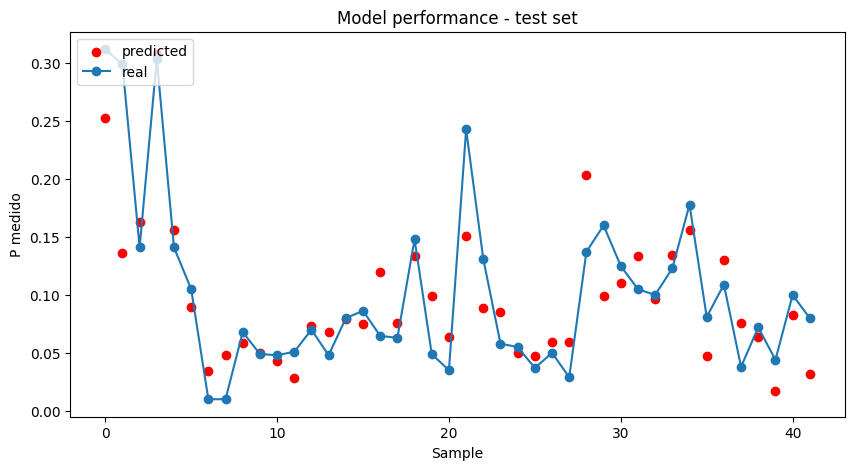

In [162]:
linear_regressor = sklm.LinearRegression()
train_test_model(linear_regressor, dataset, target, dataset, target, lambda_=0, folds=8)

**Using train and test sets**

--------------------Validação Cruazada-----------------------
Média dos valore de MAE: 0.049417311986508596
Desvio padrão dos valore de MAE: 0.0038519566872291535

Média dos valore de MAPE: 0.6354845499196071
Desvio padrão dos valore de MAPE: 0.1424408301905901

Média dos valore de MSE: 0.004582996228819106
Desvio padrão dos valore de MSE: 0.00044479166710885393

Média dos valore de R2: 0.13807167637439938
Desvio padrão dos valore de R2: 0.2945032247230127

--------------------Teste-----------------------
MAE: 0.022981936018342402
MAPE: 1.0626775817951741
MSE: 0.0008038819166129333
R2: 0.6245928210983052


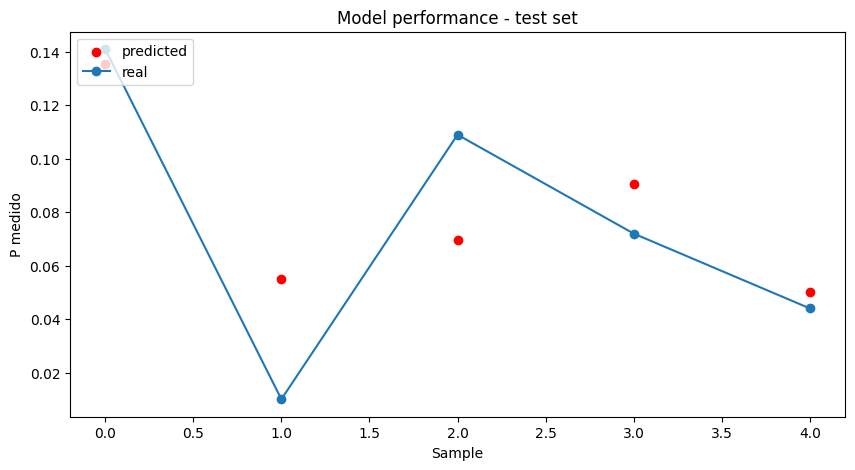

In [163]:
linear_regressor = sklm.LinearRegression()
train_test_model(linear_regressor, x_tr, y_tr, x_te, y_te, lambda_=0, folds=4)

In [164]:
print("Coeficientes da regressão linear: " + str(linear_regressor.coef_))

Coeficientes da regressão linear: [ 5.30166701e-03  1.70338591e-07 -2.36213727e-05 -2.55821930e-08
 -1.01636171e-06]


### 11.2.2. Ridge Regression

In [ ]:
ray.init()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# definindo espaço de busca para os lambdas
lambdas = np.linspace(0, 1000000, 10000)

**5-Folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=5,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

**10-folds**

In [ ]:
@ray.remote

def test_lambda(lamb):
  # aplicando a regressão
  ridge = sklm.Ridge(alpha = lamb)
  ridge.fit(x_tr, y_tr)             # Fit a ridge regression on the training data

  scores = skms.cross_validate(ridge, x_tr, y_tr, cv=10,
                               scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))

  mae = np.mean(scores['test_neg_mean_absolute_error']*(-1))
  mape = np.mean(scores['test_neg_mean_absolute_percentage_error']*(-1))
  r2 = np.mean(scores['test_r2'])

  return [mae, mape, r2]

In [ ]:
result_values = ray.get([test_lambda.remote(i) for i in lambdas])
scores_MAE = [result[0] for result in result_values]
scores_MAPE = [result[1] for result in result_values]
scores_R2 = [result[2] for result in result_values]

In [ ]:
best_index = scores_MAE.index(min(scores_MAE))

print("Lambda:" + str(lambdas[best_index]))
print("Best MAE: " + str(scores_MAE[best_index]))
print("Best MAPE: " + str(scores_MAPE[best_index]))
print("R2: " + str(scores_R2[best_index]))

ridge = sklm.Ridge(alpha = lambdas[best_index])
ridge.fit(x_tr, y_tr)
plot_results(ridge.predict(x_te), y_te)

In [ ]:
y_pred = ridge.predict(x_te)
print('-----------Teste-------------')
print("MAE: " + str(mean_absolute_error(y_te, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_te, y_pred)))
print("R2: " + str(r2_score(y_te, y_pred)))

## 11.2 Non-linear Methods

### 11.2.1. SVM

In [ ]:
from sklearn import svm

**5-Folds**

In [ ]:
svm_regressor = svm.SVR()
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**10-Folds**

In [ ]:
train_test_model(svm_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as rf

In [ ]:
rf_regressor = rf(n_estimators=1000, random_state=1)
rf_regressor.fit(x_tr, y_tr)

**5-Folds**

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=5)

**10-Folds**

In [ ]:
train_test_model(rf_regressor, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.3 Gradient Boost

In [ ]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10, 20],
        'max_features': ['log2', 0.25, 'sqrt', 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(GradientBoostingRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
gb = GradientBoostingRegressor(n_estimators=200,learning_rate=0.025,
 max_depth=3,
 max_features='log2',
 min_samples_split=2,
 subsample=0.15
)


train_test_model(gb, x_tr, y_tr, x_te, y_te, folds=10)

### 11.2.4 CatBoost

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 6, 9],
        'leaf_estimation_iterations': [1, 10],
        'l2_leaf_reg': [1, 3, 6, 9]}

clf = GridSearchCV(CatBoostRegressor(iterations=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
ctb = CatBoostRegressor(n_estimators=200,l2_leaf_reg= 1,
 leaf_estimation_iterations= 10,
 learning_rate= 0.3,
 max_depth= 6)


train_test_model(ctb, x_tr, y_tr, x_te, y_te, folds=10)

In [ ]:
ctb.get_feature_importance(prettified=True)

### 11.2.5 XGBoost

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10, 100],
        'gamma':[0, 0.1, 0.2, 0.3, 0.4, 1.0, 1.5, 2.0],
        'colsample_bylevel': ['log2', 'sqrt', 0.25, 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(XGBRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_tr)
clf.best_params_

In [ ]:
xgb = XGBRegressor(n_estimators=200,colsample_bylevel=0.25,
 gamma=0,
 learning_rate=0.025,
 max_depth=10,
 subsample=0.15
)


train_test_model(ctb, x_tr, y_tr, x_te, y_te, folds=10)

In [ ]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%writefile no_code.tpl
{% extends 'article.tplx' %}

{% block input_group %}
{% endblock input_group %}

In [ ]:
!cp /content/drive/MyDrive/CNN_Chagas/fosforo/Cópia_de_Analise_fosforo.ipynb ./

In [ ]:
!jupyter nbconvert --to pdf  "Cópia_de_Analise_fosforo.ipynb"